# 10.9 Lab: Deep Learning

Imports

In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [3]:
from torchmetrics import MeanAbsoluteError, R2Score
from torchinfo import summary
from torchvision.io import read_image

In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [5]:
# from pytorch_lightning.utilities.seed import seed_everything # OLD
from lightning_fabric.fabric import seed_everything
seed_everything(0, workers=True)
# torch.use_deterministic_algorithms(mode=True, warn_only=True)

Seed set to 0


0

In [6]:
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Resize, Normalize, CenterCrop, ToTensor

In [7]:
from ISLP.torch import SimpleModule, SimpleDataModule, ErrorTracker, rec_num_workers

In [8]:
from ISLP.torch.imdb import load_lookup, load_tensor, load_sparse, load_sequential

In [9]:
from glob import glob
import json

## 10.9.1 Single Layer Network on Hitters Data

In [10]:
Hitters = load_data("Hitters").dropna()

In [11]:
model = MS(Hitters.columns.drop("Salary"), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters["Salary"].to_numpy()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=1/3, random_state=1)

### Linear Models

In [13]:
hit_lm = LinearRegression().fit(X_train, y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - y_test).mean()

259.7152883314631

In [14]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[("scaler", scaler),
                                 ("lasso", lasso)])

In [15]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(y_train - y_train.mean())).max() / n
param_grid = {"alpha": np.exp(np.linspace(0, np.log(0.01), 100)) * lam_max}

In [16]:
cv = KFold(10,
           shuffle=True,
           random_state=1)
grid = GridSearchCV(lasso,
                    param_grid,
                    cv=cv,
                    scoring="neg_mean_absolute_error")
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(max_iter=30000, warm_start=True),
             param_grid={'alpha': array([255.65755026, 244.03752004, 232.94563812, 222.35789935,
       212.25138966, 202.60423642, 193.39556119, 184.60543446,
       176.21483255, 168.20559645, 160.5603925 , 153.26267486,
       146.29664975, 139.64724123, 133.3000586 , 127.24136521,
       121.45...
        10.81237873,  10.32093943,   9.8518368 ,   9.40405561,
         8.97662677,   8.56862523,   8.17916799,   7.80741218,
         7.45255325,   7.1138232 ,   6.79048896,   6.48185076,
         6.18724064,   5.906021  ,   5.63758323,   5.38134637,
         5.13675587,   4.90328239,   4.68042064,   4.4676883 ,
         4.26462497,   4.07079118,   3.88576744,   3.70915331,
         3.54056657,   3.37964236,   3.2260324 ,   3.07940424,
         2.93944057,   2.80583846,   2.67830877,   2.5565755 ])},
             scoring='neg_mean_absolute_error')

In [17]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - y_test).mean()

257.23820107995

### Specifying a network: Classes and Inheritance

In [18]:
class HittersModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1)
        )
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [19]:
hits_model = HittersModel(X.shape[1])

In [20]:
summary(hits_model,
        input_size=X_train.shape,
        col_names=["input_size",
                   "output_size",
                   "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [21]:
X_train_t = torch.tensor(X_train.astype(np.float32))
y_train_t = torch.tensor(y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, y_train_t)

In [22]:
X_test_t = torch.tensor(X_test.astype(np.float32))
y_test_t = torch.tensor(y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, y_test_t)

In [23]:
max_workers = rec_num_workers()

In [24]:
hit_dm = SimpleDataModule(hit_train,
                          hit_test,
                          batch_size=32,
                          num_workers=min(4, max_workers),
                          validation=hit_test)

In [25]:
hit_module = SimpleModule.regression(hits_model,
                                     metrics={"mae":MeanAbsoluteError()})

In [26]:
hit_logger = CSVLogger("logs", name="hitters")

In [27]:
hit_trainer = Trainer(max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 204.42it/s]

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 68.71it/s, v_num=1]            

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 63.13it/s, v_num=1]


In [28]:
hit_trainer.test(hit_module, datamodule=hit_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 137.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss               123543.3125
        test_mae            248.27792358398438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 123543.3125, 'test_mae': 248.27792358398438}]

In [29]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [32]:
hit_results

,step,epoch,train_mae_step,valid_loss,valid_mae,train_mae_epoch,train_loss,test_loss,test_mae
0,4,0,331.035126,NaN,NaN,NaN,NaN,NaN,NaN
1,5,0,NaN,143938.828125,237.721832,NaN,NaN,NaN,NaN
2,5,0,NaN,NaN,NaN,552.164978,811154.375000,NaN,NaN
3,9,1,228.919968,NaN,NaN,NaN,NaN,NaN,NaN
4,11,1,NaN,140019.484375,239.368225,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
156,294,49,265.289673,NaN,NaN,NaN,NaN,NaN,NaN
157,299,49,210.600296,NaN,NaN,NaN,NaN,NaN,NaN
158,299,49,NaN,123543.312500,248.277924,NaN,NaN,NaN,NaN
159,299,49,NaN,NaN,NaN,252.673508,137719.765625,NaN,NaN


In [42]:
def summary_plot(results,
                 ax,
                 col="loss",
                 valid_legend="Validation",
                 training_legend="Training",
                 ylabel="Loss",
                 fontsize=20):
   for (column, 
         color,
         label) in zip([f"train_{col}_epoch",
                        f"valid_{col}"],
                        ["black",
                         "red"],
                         [training_legend,
                          valid_legend]):
        results.plot(x="epoch",
                     y=column,
                     label=label,
                     marker="o",
                     color=color,
                     ax=ax)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(ylabel)
   return ax

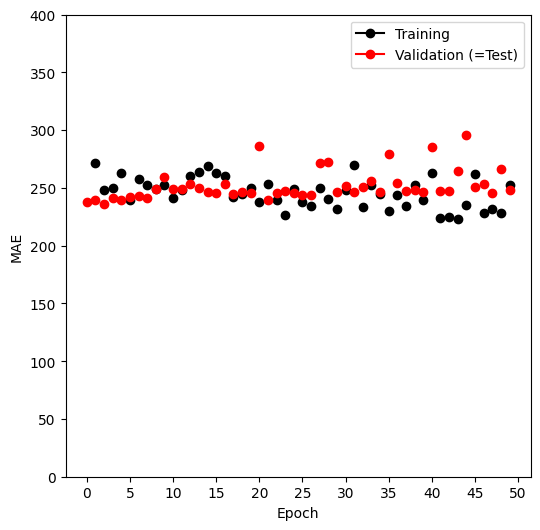

In [43]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results,
                  ax,
                  col="mae",
                  ylabel="MAE",
                  valid_legend="Validation (=Test)")
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

In [44]:
hits_model.eval()
preds = hit_module(X_test_t)
torch.abs(y_test_t - preds).mean()

tensor(248.2779, grad_fn=<MeanBackward0>)

### Cleanup

In [45]:
del(Hitters,
    hits_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    y_test, y_train,
    X_test_t, y_test_t,
    hit_trainer, hit_module)

## 10.9.2 Multilayer Network on MNIST Digit Data

In [46]:
(mnist_train,
 mnist_test) = [MNIST(root="data",
                      train=train,
                      download=True,
                      transform=ToTensor()) 
                      for train in [True, False]]
mnist_train

100%|██████████| 9912422/9912422 [00:03<00:00, 3277536.51it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68515663.93it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 829945.84it/s] 


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5346766.42it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [47]:
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_workers,
                            batch_size=256)

In [48]:
for idx, (X_, Y_) in enumerate(mnist_dm.train_dataloader()):
    print("X: ", X_.shape)
    print("Y: ", Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


In [51]:
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self._forward(x)

In [52]:
mnist_model = MNISTModel()

In [53]:
mnist_model(X_).size()

torch.Size([256, 10])

In [54]:
summary(mnist_model,
        input_data=X_,
        col_names=["input_size",
                   "output_size",
                   "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [56]:
mnist_module = SimpleModule.classification(mnist_model, num_classes=10)
mnist_logger = CSVLogger("logs", name="MNIST")

In [57]:
mnist_trainer = Trainer(max_epochs=30,
                        logger=mnist_logger,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/MNIST
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNISTModel       | 235 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 188/188 [00:02<00:00, 79.49it/s, v_num=0]        

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 188/188 [00:02<00:00, 79.08it/s, v_num=0]


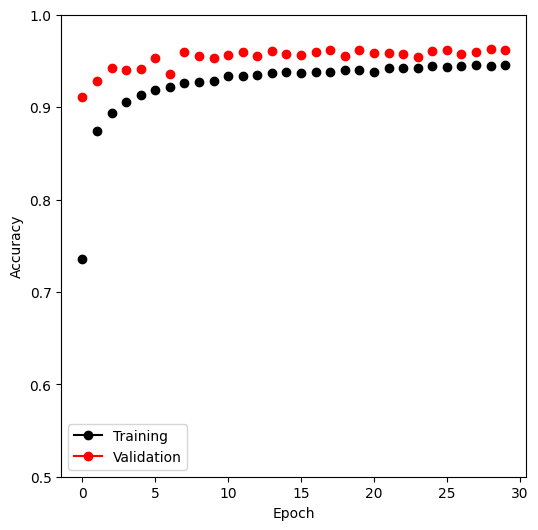

In [58]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results,
             ax,
             col="accuracy",
             ylabel="Accuracy")
ax.set_ylim([0.5, 1])
ax.set_ylabel("Accuracy")
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

In [59]:
mnist_trainer.test(mnist_module,
                   datamodule=mnist_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 189.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9617999792098999
        test_loss           0.15074127912521362
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.15074127912521362, 'test_accuracy': 0.9617999792098999}]

In [60]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)
mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model, num_classes=10)
mlr_logger = CSVLogger("logs", name="MNIST_MLR")

In [64]:
mlr_trainer = Trainer(max_epochs=30,
                      callbacks=[ErrorTracker()],
                      logger=mlr_logger)
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNIST_MLR        | 7.9 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 29: 100%|██████████| 188/188 [00:02<00:00, 87.43it/s, v_num=0]        

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 188/188 [00:02<00:00, 87.19it/s, v_num=0]


In [65]:
mlr_trainer.test(mlr_module,
                 datamodule=mnist_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 196.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9182000160217285
        test_loss           0.3516329228878021
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3516329228878021, 'test_accuracy': 0.9182000160217285}]

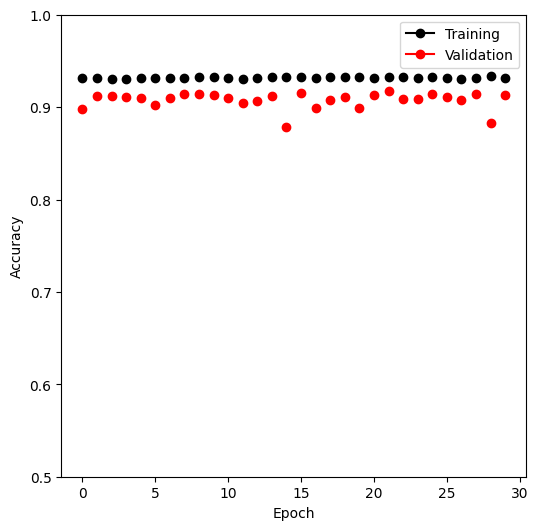

In [66]:
mnist_mlr_results = pd.read_csv(mlr_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_mlr_results,
             ax,
             col="accuracy",
             ylabel="Accuracy")
ax.set_ylim([0.5, 1])
ax.set_ylabel("Accuracy")
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

In [67]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer
    )